In [1]:
import time
import os
import shutil
import sys
import h5py
import tensorflow                     as tf
import numpy                                  as np
import seaborn                                as sns
import pandas                                 as pd
import numpy.random                           as random
from sklearn.utils                        import shuffle
from sklearn.model_selection              import train_test_split
from tqdm                                 import tqdm
from os                                   import path
import pysftp                                 as sftp

LocalFlg         = 'False'
if (not LocalFlg):
    WORKSPACE_PATH = "/home/venturi/WORKSPACE/"
    IP             = '128.174.245.172'
    User           = "venturi"
else:
    WORKSPACE_PATH = os.getenv('WORKSPACE_PATH')  
    
import matplotlib                             as mpl
import matplotlib.pyplot                      as plt
plt.style.use(WORKSPACE_PATH+'/SurQCT/surqct/scripts/postprocessing/presentation.mplstyle')

import random                                 as rnd

print("="*50)
print(" TensorFlow version: {}".format(tf.__version__))
print(" Eager execution: {}".format(tf.executing_eagerly()))

 TensorFlow version: 2.4.1
 Eager execution: True


In [2]:
pd.set_option('display.max_columns', None)  
sns.set_style('ticks')
plt.rc('text', usetex=True)
# plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{tikz} \usepackage[utf8]{inputenc}')
# plt.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
plt.rc('font', family='Times')
sns.set_context("notebook", font_scale=1.5)
plt.rcParams['xtick.labelsize'] = 40
plt.rcParams['ytick.labelsize'] = 40
plt.rcParams['axes.labelsize'] = 40
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['legend.fontsize'] = 35

In [3]:
Dimension   = 'nondim'
InelRunNb   = 9
ExchRunNb   = 6
DissRunNb   = 55
ReactionFlgQCT    = '2_1_1_0'
ReactionFlgSurQCT = '2_1_1_0'
TempVec = [5000, 10000, 20000]
PopPlotTime = [1e-6]

import Initialize_System
import Initialize_Paths as Paths

SystName    = 'O3_UMN'
Initialize = getattr(Initialize_System,'Initialize_'+SystName)
System = Initialize()

QCT_ME_path    = Paths.Workspace_path + 'Air_Database/' + System.QCTMEPath
SurQCT_ME_path = Paths.Workspace_path + 'Air_Database/Run_0D_surQCT/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

Data_ME_path   = Paths.Surqct_path + '0D/Data/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'
Figure_ME_path = Paths.Surqct_path + '0D/Figures/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

print('QCT Master Equation Path    :', QCT_ME_path)
print('SurQCT Master Equation Path :', SurQCT_ME_path)
print('Data Master Equation Path   :', Data_ME_path)
print('Figures Master Equation Path:', Figure_ME_path)

QCT Master Equation Path    : /home/venturi/WORKSPACE/Air_Database/Run_0D/
SurQCT Master Equation Path : /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_RunI9_E6_D55/
Data Master Equation Path   : /home/venturi/WORKSPACE/SurQCT/0D/Data/O3_UMN/nondim_RunI9_E6_D55/
Figures Master Equation Path: /home/venturi/WORKSPACE/SurQCT/0D/Figures/O3_UMN/nondim_RunI9_E6_D55/


In [4]:
SurQCTFldr          = WORKSPACE_PATH + '/SurQCT/surqct/'

Figure_ME_path      = SurQCTFldr + '../0D/Figures/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

RatesType           = 'KDiss'
NNRunIdx            = 55

PathToRunFld        = SurQCTFldr + '/../' + RatesType + '/all_temperatures/' 

TTranVec            = [8000, 10000]

iIdxVec             = np.array([1, 1000, 2000, 3000, 4000, 4581, 5000, 6000], dtype=int)

print("\n[SurQCT]: Loading Modules and Functions ...")

sys.path.insert(0, SurQCTFldr  + '/src/Reading/')
from Reading  import read_levelsdata, read_diatdata

InputFld = PathToRunFld + '/Run_' + str(NNRunIdx) + '/'
print(InputFld)
sys.path.insert(0, InputFld)

print("\n[SurQCT]: Keep Loading Modules and Functions...")
from SurQCT_Input import inputdata

print("\n[SurQCT]: Initializing Input ...")
InputData    = inputdata(WORKSPACE_PATH, SurQCTFldr)

Prefix                    = 'Run_'
InputData.NNRunIdx        = NNRunIdx
InputData.PathToRunFld    = InputData.PathToRunFld+'/'+Prefix+str(InputData.NNRunIdx)
InputData.PathToFigFld    = InputData.PathToRunFld+'/'+InputData.PathToFigFld
InputData.PathToParamsFld = InputData.PathToRunFld+'/'+InputData.PathToParamsFld
InputData.PathToDataFld   = InputData.PathToRunFld+'/Data/'                                                               
InputData.PathToParamsFld = InputData.PathToRunFld+'/Params/'

print("\n[SurQCT]: Loading Final Modules ... ")

sys.path.insert(0, SurQCTFldr  + '/src/Model/' + InputData.ApproxModel + '/')
from Model import model


InputData.DefineModelIntFlg  = 0
InputData.TrainIntFlg        = 0
InputData.TransferFlg        = False
NN_KDiss                     = model(InputData, InputData.PathToRunFld, None, None)
NN_KDiss.load_params(InputData.PathToParamsFld)

OtherVar           = InputData.OtherVar
xVarsVec_i         = InputData.xVarsVec_i + ['vqn','jqn']
xVarsVec           = list(set(xVarsVec_i))
print('[SurQCT]:   Reading Variables: ', xVarsVec)

InputData.MultFact = 1.e+8
MinValueTrain      = 1.e-18 * InputData.MultFact
MinValueTest       = 1.e-18 * InputData.MultFact

NMolecules         = len(InputData.PathToLevelsFile)

LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(InputData.PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(InputData.PathToDiatFile[iMol], InputData.Molecules[iMol], np.array(TTranVec), np.array(TTranVec))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)
    


[SurQCT]: Loading Modules and Functions ...
/home/venturi/WORKSPACE//SurQCT/surqct//../KDiss/all_temperatures//Run_55/

[SurQCT]: Keep Loading Modules and Functions...

[SurQCT]: Initializing Input ...

[SurQCT]: Loading Final Modules ... 
[SurQCT]:   Variables Selected for Training:
[SurQCT]:     x =  ['ECB_i', 'ro_i', 'rMax_i', 'TTran_i']
[SurQCT]:     y =  KDiss
[SurQCT]:   Loading ML Model from Folder: /home/venturi/WORKSPACE//SurQCT/surqct//../KDiss/all_temperatures//Run_55/MyModel
[SurQCT]:   Loading ML Model Parameters from File:  /home/venturi/WORKSPACE//SurQCT/surqct//../KDiss/all_temperatures//Run_55/Params//ModelCheckpoint/cp-46260.ckpt
[SurQCT]:   Reading Variables:  ['ro', 'ECB', 'vqn', 'jqn', 'rMax']
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/O2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/O2/UMN/FromUMN_Sorted.inp
[SurQCT]

In [5]:
def read_kdissdata(InputData, PathToHDF5File, TTra, TInt, NProcTypes):
    print('[SurQCT]:       Reading HDF5 File from: ' + PathToHDF5File + ' for Excitation Rates at Temperature ' + str(int(TTra)) + 'K')

    HDF5Exist_Flg = path.exists(PathToHDF5File)
    if (HDF5Exist_Flg):
        f = h5py.File(PathToHDF5File, 'a')
    else:
        f = {'key': 'value'}
        
    try:
        TStr  = 'T_' + str(int(TTra)) + '_' + str(int(TInt)) + '/Rates/'
        grp   = f[TStr]
        Data  = grp["Diss"]
        KDiss = Data[...]
        f.close()   

    except:    
        KDiss = None
        
    return KDiss

[SurQCT]:    TTran =  8000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 8000K
[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/O3_UMN.hdf5 for Excitation Rates at Temperature 10000K


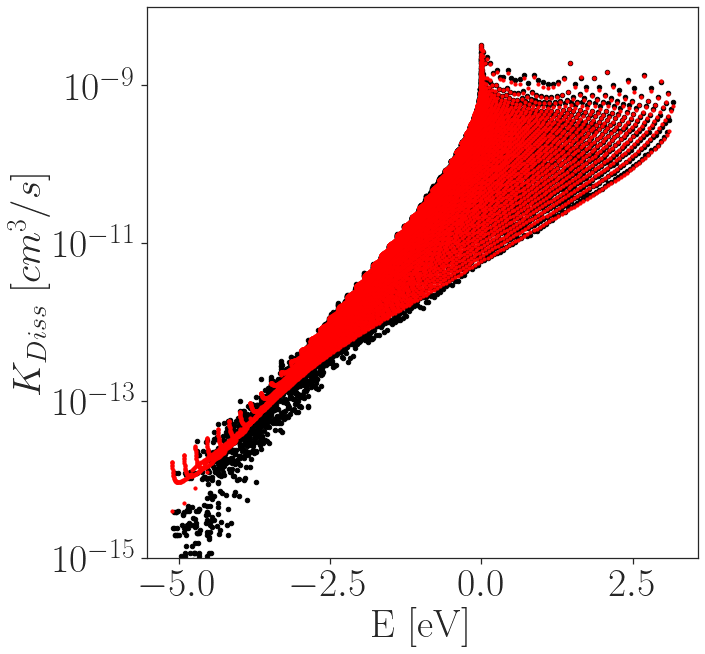

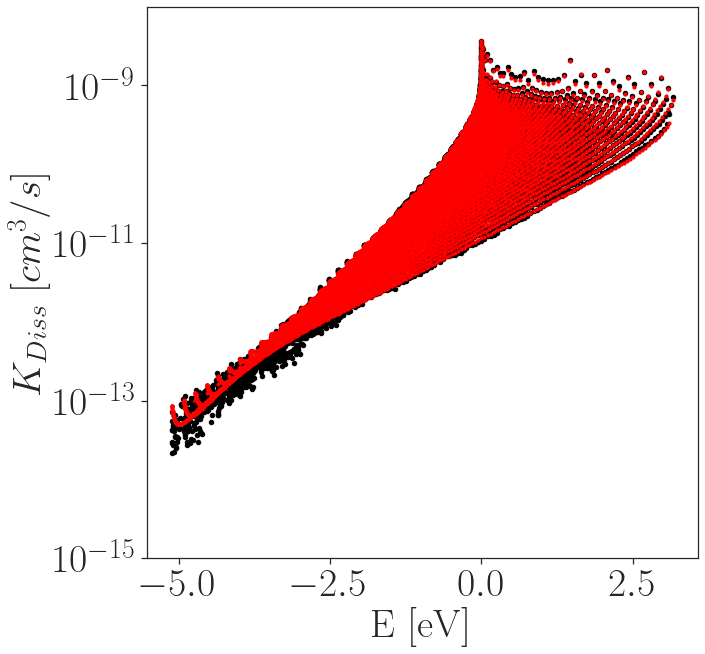

In [6]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, InputData.PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec


    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    
    ### Plotting

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k')
    plt.scatter(DiatData[1]['EInt'], KDiss_NN,   s=10, c='r')
    plt.yscale('log')
    plt.ylim([1.e-15, 1.e-8])
    plt.xlabel('E [eV]')
    plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    fig.tight_layout(pad=1.0) 
    plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KDiss.eps'), format='eps', dpi=150)

# N3 KDiss

In [7]:
Dimension   = 'nondim'
InelRunNb   = 9
ExchRunNb   = 6
DissRunNb   = 55
ReactionFlgQCT    = '1_1_1_0'
ReactionFlgSurQCT = '1_1_1_0'

import Initialize_System
import Initialize_Paths as Paths

SystName    = 'N3_NASA'
Initialize = getattr(Initialize_System,'Initialize_'+SystName)
System = Initialize()

QCT_ME_path    = Paths.Workspace_path + 'Air_Database/' + System.QCTMEPath
SurQCT_ME_path = Paths.Workspace_path + 'Air_Database/Run_0D_surQCT/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

Data_ME_path   = Paths.Surqct_path + '0D/Data/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'
Figure_ME_path = Paths.Surqct_path + '0D/Figures/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

print('QCT Master Equation Path    :', QCT_ME_path)
print('SurQCT Master Equation Path :', SurQCT_ME_path)
print('Data Master Equation Path   :', Data_ME_path)
print('Figures Master Equation Path:', Figure_ME_path)


PathToLevelsFile = [WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv',
                    WORKSPACE_PATH + '/Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv']
PathToDiatFile   = [WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp',
                    WORKSPACE_PATH + '/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp']
Molecules        = ['N2', 'N2']
PathToHDF5File   = WORKSPACE_PATH + '/Air_Database/HDF5_Database/N3_NASA.hdf5'
ScalingFact      = 1


#====================================================================
# Reading Levels Info of Initial and Final Molecules
NMolecules         = len(PathToLevelsFile)
LevelsData = []
DiatData   = []
NLevels    = []
for iMol in range(NMolecules):

    LevelsDataTemp = read_levelsdata(PathToLevelsFile[iMol], xVarsVec, '')
    LevelsData.append(LevelsDataTemp)

    DiatDataTemp = read_diatdata(PathToDiatFile[iMol], Molecules[iMol], np.array(TTranVec), np.array(TTranVec))
    DiatData.append(DiatDataTemp)

    NLevelsTemp    = LevelsDataTemp.shape[0]
    NLevels.append(NLevelsTemp)


QCT Master Equation Path    : /home/venturi/WORKSPACE/Air_Database/Run_0D_semi/
SurQCT Master Equation Path : /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_RunI9_E6_D55/
Data Master Equation Path   : /home/venturi/WORKSPACE/SurQCT/0D/Data/N3_NASA/nondim_RunI9_E6_D55/
Figures Master Equation Path: /home/venturi/WORKSPACE/SurQCT/0D/Figures/N3_NASA/nondim_RunI9_E6_D55/
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//Air_Database/Run_0D/database/levels/N2_LogER_ro_tau_rMax.csv
[SurQCT]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE//CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp


[SurQCT]:    TTran =  8000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 8000K
[SurQCT]:    TTran =  10000
[SurQCT]:       Reading HDF5 File from: /home/venturi/WORKSPACE//Air_Database/HDF5_Database/N3_NASA.hdf5 for Excitation Rates at Temperature 10000K


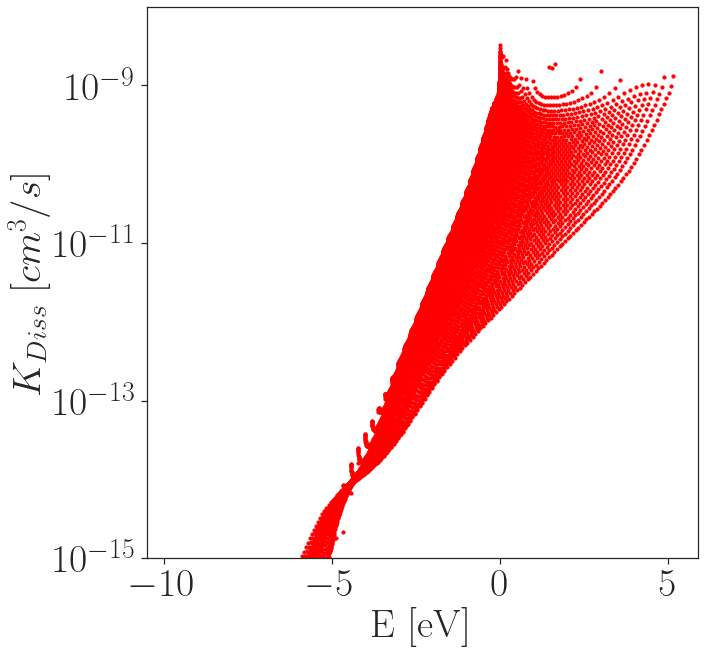

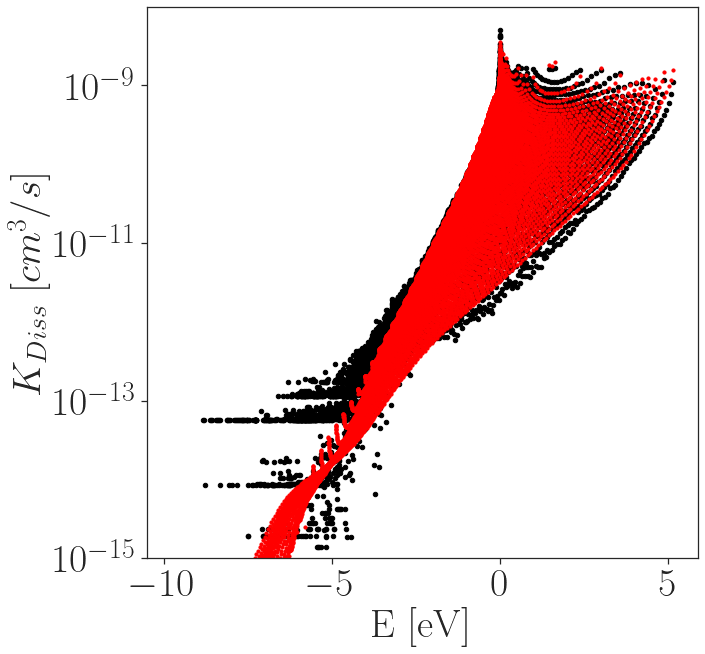

In [8]:
for TTran in TTranVec:
    print('[SurQCT]:    TTran = ', TTran)
    
    KDissAll = read_kdissdata(InputData, PathToHDF5File, TTran, TTran, 3)
    jNLevels = len(LevelsData[0])    

    ### FWD Rates
    iiIdxVec              = np.arange(jNLevels)

    TTranVecNlevels       = np.ones((jNLevels))*TTran
    TTranDataTemp         = pd.DataFrame({'TTran': TTranVecNlevels})
    TTranDataTemp.index   = iiIdxVec

    iLevelsDataTemp       = LevelsData[0].iloc[iiIdxVec,:].copy()
    iLevelsDataTemp.index = iiIdxVec

    iLevelsData           = pd.concat([iLevelsDataTemp[xVarsVec_i], TTranDataTemp], axis=1)
    iLevelsData.columns   = [(VarName + '_i') for VarName in iLevelsData.columns]

    KDiss_NN              = np.exp( NN_KDiss.Model.predict(iLevelsData[NN_KDiss.xTrainingVar]) ) / InputData.MultFact
    KDiss_NN             *= ScalingFact
    
    ### Plotting

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    if (KDissAll is not None):
        plt.scatter(DiatData[1]['EInt'], KDissAll[:,0], s=20, c='k')
    plt.scatter(DiatData[1]['EInt'], KDiss_NN,   s=10, c='r')
    plt.yscale('log')
    plt.ylim([1.e-15, 1.e-8])
    plt.xlabel('E [eV]')
    plt.ylabel(r'$K_{Diss}$ [$cm^3/s$]')
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    fig.tight_layout(pad=1.0) 
    plt.savefig((Figure_ME_path+System.Name+'_T'+str(TTran)+'K_KDiss.eps'), format='eps', dpi=150)